# 수집된 데이터에 대한 통계 분석
* 데이터 
> 2017년 12월 1일부터 2018년 2월 1일까지 63일간 [네이버](http://www.naver.com)와 [다음](http://www.daum.net)의 랭킹뉴스와 뉴스의 댓글을 크롤링함.

In [1]:
import os
import pandas as pd 
from glob import glob
import sys
import time, re, pickle, itertools
import urllib3, json
sys.path.append('~/Documents/GitHub/Private_Project/personal_project/')
import re
from operator import itemgetter
import html
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import chat_bot as cb
import Database_Handler as dh
from datetime import datetime
import seaborn as sns
import functools
%matplotlib inline

## Data 불러오기

In [2]:
def LoadDatabase(site):
    import Database_Handler as dh
    if site == 'daum':
        collection = 'newsDaum'
    elif site.lower() == 'naver':
        collection = 'newsNaver'
    mongodb = dh.ToMongoDB(*dh.AWS_MongoDB_Information())
    dbname = 'hy_db'
    useDb = dh.Use_Database(mongodb, dbname)
    useCollection = dh.Use_Collection(useDb, collection)
    collection = useCollection.find({'site':site})
    dataDict = dict()
    for data in collection:
        dataDict[data['_id']._ObjectId__id.hex()] = idData = dict()
        idData['category'] = data['category']
        idData['date'] = data['date']
        idData['press'] = data['press']
        idData['number_of_comment'] = data['number_of_comment']
        idData['number_of_crawled_comment'] = data['real_number_of_comment']
        idData['rank'] = data['rank']
        idData['title'] = data['title']
    return dataDict

In [3]:
naver = LoadDatabase('Naver')
daum = LoadDatabase('daum')

## Naver의 언론사목록 불러오기

In [4]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
def OS_Driver(browser):
    if sys.platform=='win32':
        if browser.lower() == 'phantom':
            driver = webdriver.PhantomJS('C:/Users/pc/Documents/phantomjs-2.1.1-windows/bin/phantomjs.exe')
        else:
            driver = webdriver.Chrome('C:/Users/pc/Documents/chromedriver.exe')
    elif sys.platform == 'darwin':
        if browser.lower() == 'phantom':
            driver = webdriver.PhantomJS(
                '/Users/hyunyoun/Documents/GitHub/Private_Project/phantomjs-2.1.1/bin/phantomjs')
        else:
            driver = webdriver.Chrome('/Users/hyunyoun/Documents/GitHub/Private_Project/chromedriver')
    return driver
web = 'http://news.naver.com/'
driver = OS_Driver('chrome')
driver.get(web)
driver.find_element_by_id('index.press.btn').click()
#x = driver.find_element_by_id('index.press.area')
x2 = driver.find_element_by_class_name('index_content')
x3 = x2.find_elements_by_css_selector('div')
naverpressdict = dict()
for idx in x3:
    cat = idx.find_elements_by_css_selector('h5')
    sub = idx.find_elements_by_css_selector('ul')
    sub2 = list(map(lambda x: x.find_elements_by_css_selector('a'), sub))
    sub2 = [list(map(lambda y: y.text,x)) for x in sub2]
    y = list(zip(list(map(lambda x: re.sub('[\[\]]','',x.text), cat)), list(map(lambda x: x, sub2))))
    for key, value in y:
        naverpressdict[key] = value
driver.quit()

In [5]:
naverPressList = list(itertools.chain.from_iterable(naverpressdict.values()))
naverPress = pd.DataFrame({'NAVER':naverPressList})
naverPress.head()

,NAVER
0,경향신문
1,국민일보
2,동아일보
3,문화일보
4,서울신문


### 분야별 언론사수

In [6]:
naverenrolledPress = list()
for idx in naverpressdict:
    naverenrolledPress.append((idx.strip(), len(naverpressdict[idx])))
naverenrolledPress = pd.DataFrame(naverenrolledPress)
naverenrolledPress.rename(columns={0:'category',1:'count'},inplace = True)
naverenrolledPress.set_index('category', inplace = True)
naverenrolledPress

,count
category,
종합,10
방송/통신,14
경제,10
인터넷,6
IT,6
스포츠/연예,48
매거진,16
지역,3
전문지,7


In [7]:
print ('NAVER에 등록된 언론사의 수 : {}'.format(naverenrolledPress['count'].sum()))

NAVER에 등록된 언론사의 수 : 127


## Daum의 언론사목록 불러오기

In [8]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
web = 'http://media.daum.net/cp/'
res = requests.get(web)
soup = BeautifulSoup(res.content, 'html.parser')
x1 = soup.find('div',class_='box_etc')
x2 = x1.find_all('div', class_='item_cp')

daumpressdict = dict()
count = 0 
for i in x2:
    key = i.find('h4').text
    values = i.find_all('li')
    count += len(values)
    values = list(map(lambda x: x.text.strip(), values))
    daumpressdict[key] = values

In [9]:
daumPressList = list(itertools.chain.from_iterable(daumpressdict.values()))
daumPress = pd.DataFrame({'DAUM':daumPressList})
daumPress.head()

,DAUM
0,경향신문
1,국민일보
2,뉴스1
3,뉴시스
4,동아일보


In [10]:
daumenrolledPress = list()
for idx in daumpressdict:
    daumenrolledPress.append((idx.strip(), len(daumpressdict[idx])))
daumenrolledPress = pd.DataFrame(daumenrolledPress)
daumenrolledPress.rename(columns={0:'category',1:'count'},inplace = True)
daumenrolledPress.set_index('category', inplace = True)
daumenrolledPress

,count
category,
종합,14
경제,10
온라인.인터넷,6
TV.동영상,12
스포츠.연예,24
스포츠 전문지,30
IT,8
매거진,41
전문지,7


In [11]:
print ('DAUM에 등록된 언론사의 수 : {}'.format(daumenrolledPress['count'].sum()))

DAUM에 등록된 언론사의 수 : 156


In [12]:
pickle.dump(daumpressdict,open('./data/daum_enrolled_press_by_category.pickled','wb'))
pickle.dump(naverpressdict,open('./data/naver_enrolled_press_by_category.pickled','wb'))

In [13]:
naverPress.to_csv('./data/naver_enrolled_press.csv',index=None, columns=None, encoding='utf-8')
daumPress.to_csv('./data/daum_enrolled_press.csv',index=None, columns=None, encoding='utf-8')

# 네이버와 다음에서 공통적으로 등록된 언론사

* 네이버와 다음에서 언론사를 분류한 카테고리가 다르다.
> 다음은 스포츠 관련하여 스포츠/연예, 스포츠 전문지로 구분한 반면, 네이버는 스포츠/연예로 단일 분류함  
> 네이버는 방송/통신으로 분류하였지만, 다음은 TV.동영상으로 분류함.  
> 네이버는 인터넷으로 분류하였지만, 다음은 온라인.인터넷으로 분류함.  
* 네이버는 정치, 경제, 사회, 생활/문화, 세계, IT/과학, 연예, 스포츠 별로 30개씩 랭킹을 매기고 총 240개씩 수집을 할 수 있으나, 다음은 뉴스, 연예, 스포츠 별로 50개씩 랭킹을 매기고 총 150개씩 수집을 할 수 있다.
> 앞서, 랭킹뉴스에 많이 올라간 언론사 top3를 구했을때, 네이버에서는 통신사인 연합뉴스, 뉴스1, 뉴시스였으나, 다음은 OSEN, 연합뉴스, 뉴스1이었다.  
> 다음에서 OSEN이 가장 많았던 것은 위와 같은 이유가 들어있지 않냐는 생각이다.  
* 언론사의 표기가 약간 다른 것이 존재함

In [14]:
match = pd.DataFrame({'NAVER':['KBS 뉴스', 'KBS 연예', 'MBC 뉴스', 'SBS 뉴스', 'ZDNet Korea', 'SBS CNBC', '아이즈 ize']
,'DAUM':['KBS', 'KBS', 'MBC', 'SBS', '지디넷코리아', 'SBSCNBC', 'ize']})
match

,DAUM,NAVER
0,KBS,KBS 뉴스
1,KBS,KBS 연예
2,MBC,MBC 뉴스
3,SBS,SBS 뉴스
4,지디넷코리아,ZDNet Korea
5,SBSCNBC,SBS CNBC
6,ize,아이즈 ize


In [15]:
intersectPress = set(naverPressList) & set(daumPressList)
print ('naver와 daum에 공통적으로 있는 언론사의 수 : {}'.format(len(intersectPress)+ 6))

naver와 daum에 공통적으로 있는 언론사의 수 : 91


In [16]:
naver_df = pd.DataFrame.from_dict(naver,orient='index')
naver_df['date'] = pd.to_datetime(naver_df['date']).dt.date
naver_df.reset_index(inplace = True)
naver_df.rename(columns={'index':'id'}, inplace=True)
daum_df = pd.DataFrame.from_dict(daum,orient='index')
daum_df['date'] = pd.to_datetime(daum_df['date']).dt.date
daum_df.reset_index(inplace = True)
daum_df.rename(columns={'index':'id'}, inplace=True)

In [17]:
intersectNaver = pd.concat([pd.Series(list(intersectPress)),match['NAVER']])
intersectDaum = pd.concat([pd.Series(list(intersectPress)),match['DAUM']])
intersectDaum.drop_duplicates(inplace = True)

In [18]:
xdict = dict()
for idx in match.index:
    xdict[match.loc[idx,'NAVER']] = match.loc[idx,'DAUM']

In [19]:
naverGroup = naver_df.groupby('press').count()['id'][intersectNaver]
rawNaverIndex = naverGroup.index
naverGroup.rename(index=xdict,inplace = True)
naverGroup = naverGroup.groupby(naverGroup.index).sum()
daumGroup = daum_df.groupby('press').count()['id'][intersectDaum]

In [20]:
naverGroup.index.difference(daumGroup.index)
# 제대로 변경된 것을 확인

Index([], dtype='object')

In [83]:
intersectPressPd = pd.DataFrame({'DAUM':daumGroup,
                               'DAUM_prop':daumGroup.divide(daum_df.shape[0]),
                               'NAVER':naverGroup, 
                               'NAVER_prop':naverGroup.divide(naver_df.shape[0])}).fillna(0)

In [84]:
intersectPressPd.sum(axis = 0)

DAUM           8793.000000
DAUM_prop         0.938220
NAVER         14591.000000
NAVER_prop        0.965013
dtype: float64

* 네이버와 다음에 공통적으로 등록된 언론사가 랭킹뉴스에 등록된 신문기사의 90%이상을 차지한다

## 네이버와 다음의 랭킹뉴스에 많이 올라온 신문사를 top3, top10, top20, top30까지 순위별로 찾아본다

In [86]:
def Rank_Inter_Press(intersectPress, daumpressdict, naverpressdict, rank):
    daumCat = list()
    naverCat = list()
    for idx in range(rank):
        daumPressOut = intersectPress.sort_values(by='DAUM_prop',ascending=False).index[idx]
        cat1 = [i for i, j in daumpressdict.items() if daumPressOut in j][0]
        daumCat.append(cat1)
        naverPressOut = intersectPress.sort_values(by='NAVER_prop',ascending=False).index[idx]
        cat2 = [i for i, j in naverpressdict.items() if naverPressOut in j]
        if cat2==[]:
            naverPressOut2 = match[match.DAUM.str.match('^('+naverPressOut+')$')]['NAVER'].values[0]
            cat2 = [i for i, j in naverpressdict.items() if naverPressOut2 in j][0]
        else:
            cat2 = cat2[0]
        naverCat.append(cat2)
        print ('rank : {} [ daum : {}] {} [ naver : {} ] {} '.format(idx+1, daumPressOut, cat1, naverPressOut, cat2))
    return daumCat, naverCat

### Top3

수집기간동안 랭킹뉴스에 많이 등록된 언론사
rank : 1 [ daum : 연합뉴스] 종합 [ naver : 연합뉴스 ] 방송/통신 
rank : 2 [ daum : OSEN] 스포츠.연예 [ naver : 뉴스1 ] 방송/통신 
rank : 3 [ daum : 뉴스엔] 스포츠.연예 [ naver : 뉴시스 ] 방송/통신 


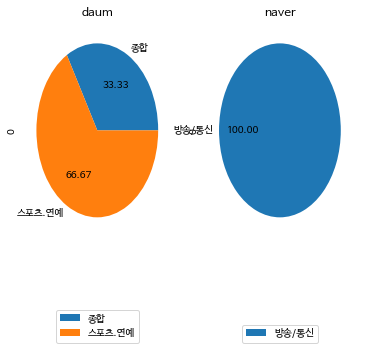

In [87]:
print ('수집기간동안 랭킹뉴스에 많이 등록된 언론사')
daumCat, naverCat = Rank_Inter_Press(intersectPressPd, daumpressdict, naverpressdict, 3)
ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(daumCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(naverCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

### Top10

수집기간동안 랭킹뉴스에 많이 등록된 언론사
rank : 1 [ daum : 연합뉴스] 종합 [ naver : 연합뉴스 ] 방송/통신 
rank : 2 [ daum : OSEN] 스포츠.연예 [ naver : 뉴스1 ] 방송/통신 
rank : 3 [ daum : 뉴스엔] 스포츠.연예 [ naver : 뉴시스 ] 방송/통신 
rank : 4 [ daum : 뉴스1] 종합 [ naver : OSEN ] 스포츠/연예 
rank : 5 [ daum : 스포츠조선] 스포츠.연예 [ naver : 중앙일보 ] 종합 
rank : 6 [ daum : 스포티비뉴스] 스포츠 전문지 [ naver : SBS ] 방송/통신 
rank : 7 [ daum : 중앙일보] 종합 [ naver : 스포츠조선 ] 스포츠/연예 
rank : 8 [ daum : TV리포트] 스포츠.연예 [ naver : 머니투데이 ] 경제 
rank : 9 [ daum : 엑스포츠뉴스] 스포츠.연예 [ naver : 조선일보 ] 종합 
rank : 10 [ daum : 마이데일리] 스포츠.연예 [ naver : 이데일리 ] 경제 


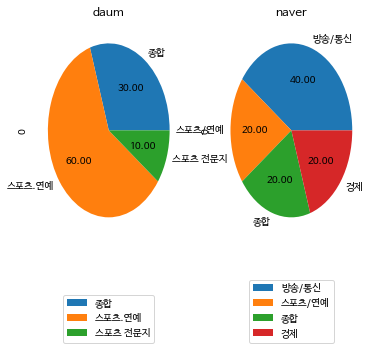

In [88]:
print ('수집기간동안 랭킹뉴스에 많이 등록된 언론사')
daumCat, naverCat = Rank_Inter_Press(intersectPressPd, daumpressdict, naverpressdict, 10)

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(daumCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(naverCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

### Top20

수집기간동안 랭킹뉴스에 많이 등록된 언론사
rank : 1 [ daum : 연합뉴스] 종합 [ naver : 연합뉴스 ] 방송/통신 
rank : 2 [ daum : OSEN] 스포츠.연예 [ naver : 뉴스1 ] 방송/통신 
rank : 3 [ daum : 뉴스엔] 스포츠.연예 [ naver : 뉴시스 ] 방송/통신 
rank : 4 [ daum : 뉴스1] 종합 [ naver : OSEN ] 스포츠/연예 
rank : 5 [ daum : 스포츠조선] 스포츠.연예 [ naver : 중앙일보 ] 종합 
rank : 6 [ daum : 스포티비뉴스] 스포츠 전문지 [ naver : SBS ] 방송/통신 
rank : 7 [ daum : 중앙일보] 종합 [ naver : 스포츠조선 ] 스포츠/연예 
rank : 8 [ daum : TV리포트] 스포츠.연예 [ naver : 머니투데이 ] 경제 
rank : 9 [ daum : 엑스포츠뉴스] 스포츠.연예 [ naver : 조선일보 ] 종합 
rank : 10 [ daum : 마이데일리] 스포츠.연예 [ naver : 이데일리 ] 경제 
rank : 11 [ daum : 스포탈코리아] 스포츠 전문지 [ naver : 한겨레 ] 종합 
rank : 12 [ daum : 인터풋볼] 스포츠 전문지 [ naver : 아시아경제 ] 경제 
rank : 13 [ daum : 노컷뉴스] 온라인.인터넷 [ naver : 서울신문 ] 종합 
rank : 14 [ daum : 뉴시스] 종합 [ naver : YTN ] 방송/통신 
rank : 15 [ daum : 스포츠동아] 스포츠.연예 [ naver : 동아일보 ] 종합 
rank : 16 [ daum : 스포츠서울] 스포츠.연예 [ naver : TV리포트 ] 스포츠/연예 
rank : 17 [ daum : 일간스포츠] 스포츠.연예 [ naver : 스포탈코리아 ] 스포츠/연예 
rank : 18 [ daum : SBS] TV.동영상 [ naver : 세계일보 ] 종합 
ran

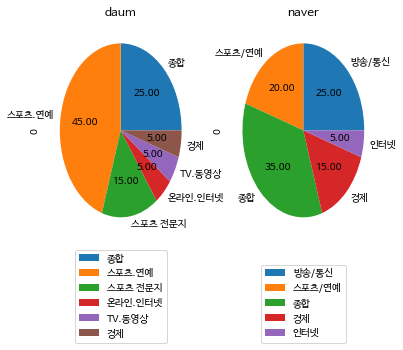

In [89]:
print ('수집기간동안 랭킹뉴스에 많이 등록된 언론사')
daumCat, naverCat = Rank_Inter_Press(intersectPressPd, daumpressdict, naverpressdict, 20)

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(daumCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(naverCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

### Top30

수집기간동안 랭킹뉴스에 많이 등록된 언론사
rank : 1 [ daum : 연합뉴스] 종합 [ naver : 연합뉴스 ] 방송/통신 
rank : 2 [ daum : OSEN] 스포츠.연예 [ naver : 뉴스1 ] 방송/통신 
rank : 3 [ daum : 뉴스엔] 스포츠.연예 [ naver : 뉴시스 ] 방송/통신 
rank : 4 [ daum : 뉴스1] 종합 [ naver : OSEN ] 스포츠/연예 
rank : 5 [ daum : 스포츠조선] 스포츠.연예 [ naver : 중앙일보 ] 종합 
rank : 6 [ daum : 스포티비뉴스] 스포츠 전문지 [ naver : SBS ] 방송/통신 
rank : 7 [ daum : 중앙일보] 종합 [ naver : 스포츠조선 ] 스포츠/연예 
rank : 8 [ daum : TV리포트] 스포츠.연예 [ naver : 머니투데이 ] 경제 
rank : 9 [ daum : 엑스포츠뉴스] 스포츠.연예 [ naver : 조선일보 ] 종합 
rank : 10 [ daum : 마이데일리] 스포츠.연예 [ naver : 이데일리 ] 경제 
rank : 11 [ daum : 스포탈코리아] 스포츠 전문지 [ naver : 한겨레 ] 종합 
rank : 12 [ daum : 인터풋볼] 스포츠 전문지 [ naver : 아시아경제 ] 경제 
rank : 13 [ daum : 노컷뉴스] 온라인.인터넷 [ naver : 서울신문 ] 종합 
rank : 14 [ daum : 뉴시스] 종합 [ naver : YTN ] 방송/통신 
rank : 15 [ daum : 스포츠동아] 스포츠.연예 [ naver : 동아일보 ] 종합 
rank : 16 [ daum : 스포츠서울] 스포츠.연예 [ naver : TV리포트 ] 스포츠/연예 
rank : 17 [ daum : 일간스포츠] 스포츠.연예 [ naver : 스포탈코리아 ] 스포츠/연예 
rank : 18 [ daum : SBS] TV.동영상 [ naver : 세계일보 ] 종합 
ran

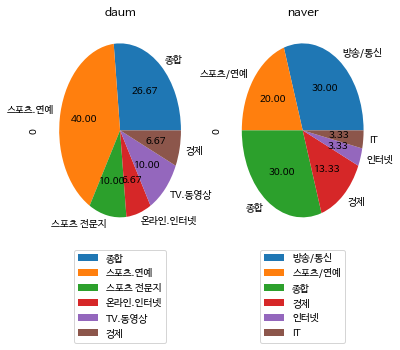

In [90]:
print ('수집기간동안 랭킹뉴스에 많이 등록된 언론사')
daumCat, naverCat = Rank_Inter_Press(intersectPressPd, daumpressdict, naverpressdict, 30)

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(daumCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(naverCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

* 다음에서는 스포츠/연예 또는 스포츠 전문지가 전체의 50%를 차지한다. 
> 이는 다음의 랭킹뉴스를 분류하는 기준이 종합, 연예, 스포츠 3가지이며 각각 50개가 존재하기 때문에 스포츠/연예 도는 스포츠 전문지가 상대적으로 더 많은 비율을 차지하는 것으로 보인다.  
* 네이버에서는 방송/통신 또는 종합이 전체의 60%를 차지한다. 
> 이는 네이버의 랭킹뉴스를 분류하는 기준이 정치, 경제, 사회, 생활/문화, 세계, IT/과학, 연예, 스포츠 8가지이며 각각 30개가 존재하기 때문에 다양한 분야를 취급하는 종합 또는 방송/통신 분류에 속하는 언론사들이 많은 비율을 차지하는 것으로 보인다. 

### NAVER와 DAUM 양쪽에 공통된 언론사중 랭킹뉴스가 단 한건도 올라가지 않은 언론사를 찾아보자

In [104]:
notRankedPress = intersectPressPd[(intersectPressPd.DAUM ==0) & (intersectPressPd.NAVER == 0)]
print ('''총 {} 언론사가 NAVER와 DAUM 양쪽의 랭킹뉴스에 한건도 올라가지 않았다.
해당 언론사는 {} 이다.'''.format(notRankedPress.shape[0], ', '.join(notRankedPress.index.values)))

총 3 언론사가 NAVER와 DAUM 양쪽의 랭킹뉴스에 한건도 올라가지 않았다.
해당 언론사는 기자협회보, 로이터, 정책브리핑 이다.


## 언론사에 따라 기사마다 평균적으로 얼마나 댓글이 달리는지 알아보자
> * 댓글수는 크롤링한 댓글수가 아닌 뉴스에 나와있는 댓글수를 가지고 이용하였다. 
> * 이는 전체 댓글수로 사용자가 삭제하거나 신고하여 삭제된 것등을 포함된 댓글수이다. 

In [105]:
import Database_Handler as dh
mongodb = dh.ToMongoDB(*dh.AWS_MongoDB_Information())
dbname = 'hy_db'
useDb = dh.Use_Database(mongodb, dbname)
commentsCollection = dh.Use_Collection(useDb, 'comments')
daumComments = commentsCollection.find({'site':'daum'})
numDaumComments = daumComments.count()
naverComments = commentsCollection.find({'site':'Naver'})
numNaverComments = naverComments.count()

In [209]:
naverGroup = naver_df.groupby('press').sum()['number_of_comment'][intersectNaver]
rawNaverIndex = naverGroup.index
naverGroup.rename(index=xdict,inplace = True)
naverGroup = naverGroup.groupby(naverGroup.index).sum()
daumGroup = daum_df.groupby('press').sum()['number_of_comment'][intersectDaum]

intersectPressComment = pd.DataFrame({'DAUM':daumGroup,
                               'DAUM_prop':daumGroup.divide(daum_df['number_of_comment'].sum())*100,
                               'NAVER':naverGroup, 
                               'NAVER_prop':naverGroup.divide(naver_df['number_of_comment'].sum())*100}).fillna(0)
intersectPressComment.sum(axis = 0).round(2).astype('float64')

DAUM           5883913.00
DAUM_prop           98.15
NAVER         13610524.00
NAVER_prop          97.52
dtype: float64

In [210]:
print ('DAUM의 전체 댓글수는 {}이고, NAVER의 전체 댓글수는 {}이다'.format(daum_df['number_of_comment'].sum(), naver_df['number_of_comment'].sum()))

DAUM의 전체 댓글수는 5994887이고, NAVER의 전체 댓글수는 13956005이다


* 수집된 다음과 네이버 전체 뉴스에 대하여 전체 댓글중 98% 가까운 댓글이 네이버와 다음에서 공통적으로 존재하는 언론사의 기사에 나타나는 것을 확인할 수 있다. 

### 댓글수의 비율에 따라 언론사의 랭킹을 매겨보자

In [221]:
def rank_press_category(site, df, pd, rank):
    catList = list()
    for idx in range(rank):
        po1 = df.index.values[idx]
        if site.lower() =='daum':
            cat = [i for i, j in pd.items() if po1 in j][0]
            catList.append([po1,cat])
        else:
            cat = [i for i, j in pd.items() if po1 in j]
            if cat==[]:
                po2 = match[match.DAUM.str.match('^('+po1+')$')]['NAVER'].values[0]
                cat = [i for i, j in pd.items() if po2 in j][0]
            else:
                cat = cat[0]
            catList.append([po1,cat])
    return catList

In [214]:
def Sort_by_value(pd, value, rank):
    pd = pd.sort_values(by=value, ascending = False)
    return pd[:rank]

### 상위 5

각 포털 별로 댓글의 비율이 상위 5에 들어가는 언론사는 아래와 같다. 
DAUM : 연합뉴스|종합, 뉴스1|종합, 중앙일보|종합, 노컷뉴스|온라인.인터넷, 뉴시스|종합
NAVER : 연합뉴스|방송/통신, 뉴스1|방송/통신, 뉴시스|방송/통신, SBS|방송/통신, 머니투데이|경제


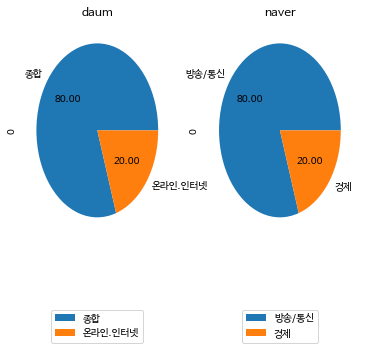

In [234]:
rank = 5
dt = rank_press_category('daum',
                         Sort_by_value(intersectPressComment, 'DAUM_prop',rank),
                         daumpressdict, rank)
nt = rank_press_category('naver',
                         Sort_by_value(intersectPressComment, 'NAVER_prop',rank),
                         naverpressdict, rank)
print ('''각 포털 별로 댓글의 비율이 상위 {}에 들어가는 언론사는 아래와 같다. 
DAUM : {}
NAVER : {}'''.format(rank, ', '.join(list(map(lambda x: '|'.join(x), dt))), ', '.join(list(map(lambda x: '|'.join(x), nt)))))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], dt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], nt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

### 상위 10

각 포털 별로 댓글의 비율이 상위 10에 들어가는 언론사는 아래와 같다. 
DAUM : 연합뉴스|종합, 뉴스1|종합, 중앙일보|종합, 노컷뉴스|온라인.인터넷, 뉴시스|종합, SBS|TV.동영상, 머니투데이|경제, 조선일보|종합, 경향신문|종합, 한겨레|종합
NAVER : 연합뉴스|방송/통신, 뉴스1|방송/통신, 뉴시스|방송/통신, SBS|방송/통신, 머니투데이|경제, 중앙일보|종합, OSEN|스포츠/연예, 이데일리|경제, JTBC|방송/통신, MBC|방송/통신


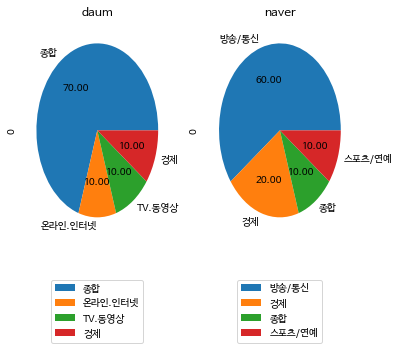

In [235]:
rank = 10
dt = rank_press_category('daum',
                         Sort_by_value(intersectPressComment, 'DAUM_prop',rank),
                         daumpressdict, rank)
nt = rank_press_category('naver',
                         Sort_by_value(intersectPressComment, 'NAVER_prop',rank),
                         naverpressdict, rank)
print ('''각 포털 별로 댓글의 비율이 상위 {}에 들어가는 언론사는 아래와 같다. 
DAUM : {}
NAVER : {}'''.format(rank, ', '.join(list(map(lambda x: '|'.join(x), dt))), ', '.join(list(map(lambda x: '|'.join(x), nt)))))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], dt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], nt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

### 상위 20

각 포털 별로 댓글의 비율이 상위 20에 들어가는 언론사는 아래와 같다. 
DAUM : 연합뉴스|종합, 뉴스1|종합, 중앙일보|종합, 노컷뉴스|온라인.인터넷, 뉴시스|종합, SBS|TV.동영상, 머니투데이|경제, 조선일보|종합, 경향신문|종합, 한겨레|종합, JTBC|TV.동영상, 한국일보|종합, 이데일리|경제, OSEN|스포츠.연예, 국민일보|종합, 동아일보|종합, 오마이뉴스|온라인.인터넷, 아시아경제|경제, 세계일보|종합, 뉴스엔|스포츠.연예
NAVER : 연합뉴스|방송/통신, 뉴스1|방송/통신, 뉴시스|방송/통신, SBS|방송/통신, 머니투데이|경제, 중앙일보|종합, OSEN|스포츠/연예, 이데일리|경제, JTBC|방송/통신, MBC|방송/통신, 스포츠조선|스포츠/연예, 노컷뉴스|인터넷, 조선일보|종합, KBS|방송/통신, 국민일보|종합, 세계일보|종합, 한국일보|종합, 동아일보|종합, 경향신문|종합, 한겨레|종합


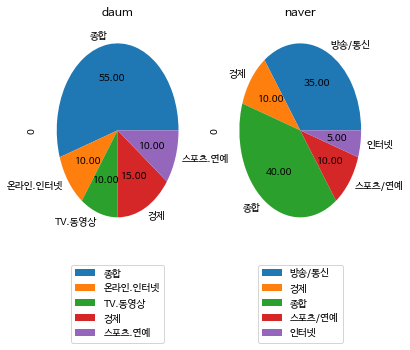

In [236]:
rank = 20
dt = rank_press_category('daum',
                         Sort_by_value(intersectPressComment, 'DAUM_prop',rank),
                         daumpressdict, rank)
nt = rank_press_category('naver',
                         Sort_by_value(intersectPressComment, 'NAVER_prop',rank),
                         naverpressdict, rank)
print ('''각 포털 별로 댓글의 비율이 상위 {}에 들어가는 언론사는 아래와 같다. 
DAUM : {}
NAVER : {}'''.format(rank, ', '.join(list(map(lambda x: '|'.join(x), dt))), ', '.join(list(map(lambda x: '|'.join(x), nt)))))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], dt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], nt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

### 상위 30

각 포털 별로 댓글의 비율이 상위 30에 들어가는 언론사는 아래와 같다. 
DAUM : 연합뉴스|종합, 뉴스1|종합, 중앙일보|종합, 노컷뉴스|온라인.인터넷, 뉴시스|종합, SBS|TV.동영상, 머니투데이|경제, 조선일보|종합, 경향신문|종합, 한겨레|종합, JTBC|TV.동영상, 한국일보|종합, 이데일리|경제, OSEN|스포츠.연예, 국민일보|종합, 동아일보|종합, 오마이뉴스|온라인.인터넷, 아시아경제|경제, 세계일보|종합, 뉴스엔|스포츠.연예, YTN|TV.동영상, 헤럴드경제|경제, MBC|TV.동영상, 스포츠조선|스포츠.연예, 매일경제|경제, 마이데일리|스포츠.연예, 시사저널|매거진, 미디어오늘|전문지 , 서울경제|경제, 채널A|TV.동영상
NAVER : 연합뉴스|방송/통신, 뉴스1|방송/통신, 뉴시스|방송/통신, SBS|방송/통신, 머니투데이|경제, 중앙일보|종합, OSEN|스포츠/연예, 이데일리|경제, JTBC|방송/통신, MBC|방송/통신, 스포츠조선|스포츠/연예, 노컷뉴스|인터넷, 조선일보|종합, KBS|방송/통신, 국민일보|종합, 세계일보|종합, 한국일보|종합, 동아일보|종합, 경향신문|종합, 한겨레|종합, 아시아경제|경제, 서울신문|종합, YTN|방송/통신, 스타뉴스|스포츠/연예, TV리포트|스포츠/연예, 일간스포츠|스포츠/연예, 채널A|방송/통신, 엑스포츠뉴스|스포츠/연예, 스포탈코리아|스포츠/연예, 파이낸셜뉴스|경제


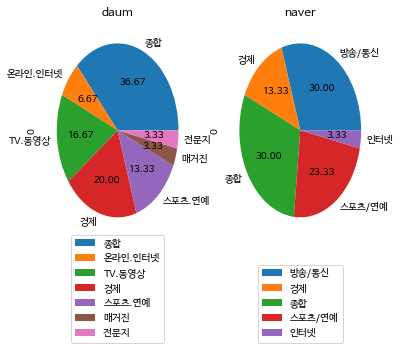

In [237]:
rank = 30
dt = rank_press_category('daum',
                         Sort_by_value(intersectPressComment, 'DAUM_prop',rank),
                         daumpressdict, rank)
nt = rank_press_category('naver',
                         Sort_by_value(intersectPressComment, 'NAVER_prop',rank),
                         naverpressdict, rank)
print ('''각 포털 별로 댓글의 비율이 상위 {}에 들어가는 언론사는 아래와 같다. 
DAUM : {}
NAVER : {}'''.format(rank, ', '.join(list(map(lambda x: '|'.join(x), dt))), ', '.join(list(map(lambda x: '|'.join(x), nt)))))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], dt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], nt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

### 평균적인 댓글수에 따라 언론사의 랭킹을 매겨보자

In [183]:
meanCommentsNaver = pd.DataFrame(naverGroup/ naver_df.groupby('press').count()['id'][intersectNaver])
meanCommentsDaum = pd.DataFrame(daumGroup / daum_df.groupby('press').count()['id'][intersectDaum])
meanCommentsDaum.dropna(inplace = True)
meanCommentsNaver.dropna(inplace = True)

### 상위 5

각 포털 별로 평균적인 댓글수가 많은 언론사 5에 들어가는 언론사는 아래와 같다. 
DAUM : 미디어오늘|전문지 , MBC|TV.동영상, 경향신문|종합, 한겨레|종합, 국민일보|종합
NAVER : 디스패치|스포츠/연예, JTBC|방송/통신, MBN|방송/통신, 머니투데이|경제, 노컷뉴스|인터넷


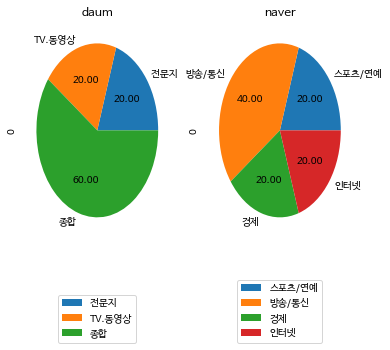

In [241]:
rank = 5
dt = rank_press_category('daum',
                         Sort_by_value(meanCommentsDaum, 0, rank),
                         daumpressdict, rank)
nt = rank_press_category('naver',
                         Sort_by_value(meanCommentsNaver, 0, rank),
                         naverpressdict, rank)
print ('''각 포털 별로 평균적인 댓글수가 많은 언론사 {}에 들어가는 언론사는 아래와 같다. 
DAUM : {}
NAVER : {}'''.format(rank, ', '.join(list(map(lambda x: '|'.join(x), dt))), ', '.join(list(map(lambda x: '|'.join(x), nt)))))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], dt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], nt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

## 상위 10

각 포털 별로 평균적인 댓글수가 많은 언론사 10에 들어가는 언론사는 아래와 같다. 
DAUM : 미디어오늘|전문지 , MBC|TV.동영상, 경향신문|종합, 한겨레|종합, 국민일보|종합, JTBC|TV.동영상, 머니투데이|경제, 한겨레21|매거진, 매일경제|경제, SBS|TV.동영상
NAVER : 디스패치|스포츠/연예, JTBC|방송/통신, MBN|방송/통신, 머니투데이|경제, 노컷뉴스|인터넷, 국민일보|종합, 시사IN|매거진, 연합뉴스|방송/통신, 뉴스1|방송/통신, 이데일리|경제


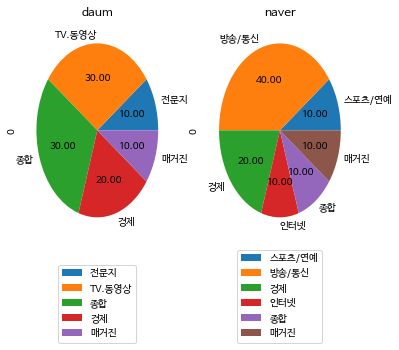

In [242]:
rank = 10
dt = rank_press_category('daum',
                         Sort_by_value(meanCommentsDaum, 0, rank),
                         daumpressdict, rank)
nt = rank_press_category('naver',
                         Sort_by_value(meanCommentsNaver, 0, rank),
                         naverpressdict, rank)
print ('''각 포털 별로 평균적인 댓글수가 많은 언론사 {}에 들어가는 언론사는 아래와 같다. 
DAUM : {}
NAVER : {}'''.format(rank, ', '.join(list(map(lambda x: '|'.join(x), dt))), ', '.join(list(map(lambda x: '|'.join(x), nt)))))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], dt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], nt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

### 상위 20

각 포털 별로 평균적인 댓글수가 많은 언론사 20에 들어가는 언론사는 아래와 같다. 
DAUM : 미디어오늘|전문지 , MBC|TV.동영상, 경향신문|종합, 한겨레|종합, 국민일보|종합, JTBC|TV.동영상, 머니투데이|경제, 한겨레21|매거진, 매일경제|경제, SBS|TV.동영상, 조선비즈|경제, 시사저널|매거진, 채널A|TV.동영상, 뉴시스|종합, 노컷뉴스|온라인.인터넷, 시사IN|매거진, 아시아경제|경제, 이데일리|경제, 조선일보|종합, 연합뉴스|종합
NAVER : 디스패치|스포츠/연예, JTBC|방송/통신, MBN|방송/통신, 머니투데이|경제, 노컷뉴스|인터넷, 국민일보|종합, 시사IN|매거진, 연합뉴스|방송/통신, 뉴스1|방송/통신, 이데일리|경제, 뉴시스|방송/통신, 프레시안|인터넷, 경향신문|종합, 한국일보|종합, 스타뉴스|스포츠/연예, 테니스코리아|스포츠/연예, 세계일보|종합, 시사저널|매거진, 채널A|방송/통신, 동아일보|종합


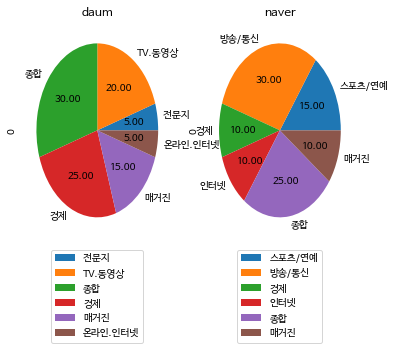

In [243]:
rank = 20
dt = rank_press_category('daum',
                         Sort_by_value(meanCommentsDaum, 0, rank),
                         daumpressdict, rank)
nt = rank_press_category('naver',
                         Sort_by_value(meanCommentsNaver, 0, rank),
                         naverpressdict, rank)
print ('''각 포털 별로 평균적인 댓글수가 많은 언론사 {}에 들어가는 언론사는 아래와 같다. 
DAUM : {}
NAVER : {}'''.format(rank, ', '.join(list(map(lambda x: '|'.join(x), dt))), ', '.join(list(map(lambda x: '|'.join(x), nt)))))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], dt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], nt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

### 상위 30

각 포털 별로 평균적인 댓글수가 많은 언론사 30에 들어가는 언론사는 아래와 같다. 
DAUM : 미디어오늘|전문지 , MBC|TV.동영상, 경향신문|종합, 한겨레|종합, 국민일보|종합, JTBC|TV.동영상, 머니투데이|경제, 한겨레21|매거진, 매일경제|경제, SBS|TV.동영상, 조선비즈|경제, 시사저널|매거진, 채널A|TV.동영상, 뉴시스|종합, 노컷뉴스|온라인.인터넷, 시사IN|매거진, 아시아경제|경제, 이데일리|경제, 조선일보|종합, 연합뉴스|종합, 동아일보|종합, 한국일보|종합, 주간동아|매거진, 중앙일보|종합, 헤럴드경제|경제, 머니S|온라인.인터넷, 세계일보|종합, 뉴스1|종합, 한국경제|경제, 서울경제|경제
NAVER : 디스패치|스포츠/연예, JTBC|방송/통신, MBN|방송/통신, 머니투데이|경제, 노컷뉴스|인터넷, 국민일보|종합, 시사IN|매거진, 연합뉴스|방송/통신, 뉴스1|방송/통신, 이데일리|경제, 뉴시스|방송/통신, 프레시안|인터넷, 경향신문|종합, 한국일보|종합, 스타뉴스|스포츠/연예, 테니스코리아|스포츠/연예, 세계일보|종합, 시사저널|매거진, 채널A|방송/통신, 동아일보|종합, 중앙일보|종합, 스포츠동아|스포츠/연예, 텐아시아|스포츠/연예, 조선일보|종합, 일간스포츠|스포츠/연예, 스포츠조선|스포츠/연예, 베스트일레븐|스포츠/연예, 마이데일리|스포츠/연예, 미디어오늘|인터넷, SBS funE|스포츠/연예


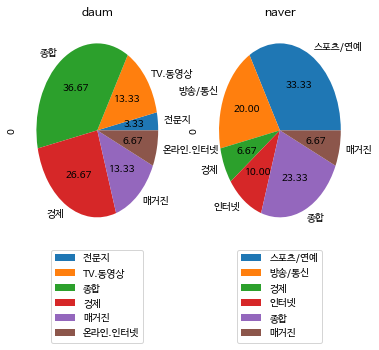

In [244]:
rank = 30
dt = rank_press_category('daum',
                         Sort_by_value(meanCommentsDaum, 0, rank),
                         daumpressdict, rank)
nt = rank_press_category('naver',
                         Sort_by_value(meanCommentsNaver, 0, rank),
                         naverpressdict, rank)
print ('''각 포털 별로 평균적인 댓글수가 많은 언론사 {}에 들어가는 언론사는 아래와 같다. 
DAUM : {}
NAVER : {}'''.format(rank, ', '.join(list(map(lambda x: '|'.join(x), dt))), ', '.join(list(map(lambda x: '|'.join(x), nt)))))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], dt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(list(map(lambda x: x[1], nt))),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

In [254]:
mcd = Sort_by_value(meanCommentsDaum, 0, 30)
mcn = Sort_by_value(meanCommentsNaver, 0, 30)
for idx in range(30):
    print ('rank : {}, DAUM : {}, NAVER : {}'.format(idx+1, mcd.index.values[idx], mcn.index.values[idx]))

rank : 1, DAUM : 미디어오늘, NAVER : 디스패치
rank : 2, DAUM : MBC, NAVER : JTBC
rank : 3, DAUM : 경향신문, NAVER : MBN
rank : 4, DAUM : 한겨레, NAVER : 머니투데이
rank : 5, DAUM : 국민일보, NAVER : 노컷뉴스
rank : 6, DAUM : JTBC, NAVER : 국민일보
rank : 7, DAUM : 머니투데이, NAVER : 시사IN
rank : 8, DAUM : 한겨레21, NAVER : 연합뉴스
rank : 9, DAUM : 매일경제, NAVER : 뉴스1
rank : 10, DAUM : SBS, NAVER : 이데일리
rank : 11, DAUM : 조선비즈, NAVER : 뉴시스
rank : 12, DAUM : 시사저널, NAVER : 프레시안
rank : 13, DAUM : 채널A, NAVER : 경향신문
rank : 14, DAUM : 뉴시스, NAVER : 한국일보
rank : 15, DAUM : 노컷뉴스, NAVER : 스타뉴스
rank : 16, DAUM : 시사IN, NAVER : 테니스코리아
rank : 17, DAUM : 아시아경제, NAVER : 세계일보
rank : 18, DAUM : 이데일리, NAVER : 시사저널
rank : 19, DAUM : 조선일보, NAVER : 채널A
rank : 20, DAUM : 연합뉴스, NAVER : 동아일보
rank : 21, DAUM : 동아일보, NAVER : 중앙일보
rank : 22, DAUM : 한국일보, NAVER : 스포츠동아
rank : 23, DAUM : 주간동아, NAVER : 텐아시아
rank : 24, DAUM : 중앙일보, NAVER : 조선일보
rank : 25, DAUM : 헤럴드경제, NAVER : 일간스포츠
rank : 26, DAUM : 머니S, NAVER : 스포츠조선
rank : 27, DAUM : 세계일보, NAVER : 베스트일레븐
rank : 

* 평균 댓글수로 언론사의 순위를 매겼을때, 댓글의 비율과는 차이를 보인다.
> 기사의 수가 많으면 당연히 댓글의 비율이 늘어나니, 그럴 수 밖에 없을 것이라고 판단된다. 

* 네이버에서 디스패치가 평균 댓글수가 1위인 것을 보니 열애설과 관련된 특종을 터뜨린 것 같다. 

In [255]:
naveris = naver_df.groupby(['date','category','press']).sum()['number_of_comment'].unstack()
daumis = daum_df.groupby(['date','category','press']).sum()['number_of_comment'].unstack()

In [256]:
propbycat_naver = naveris.sum(axis = 1).unstack().sum() / naver_df['number_of_comment'].sum() * 100
propbycat_daum = daumis.sum(axis = 1).unstack().sum() / daum_df['number_of_comment'].sum() * 100

In [257]:
propbycat_naver.sort_values(ascending=False)

category
정치       31.775662
사회       23.841665
경제       14.106143
연예        9.103888
스포츠       7.926717
세계        5.597626
생활/문화     5.351173
IT/과학     2.297126
dtype: float64

In [258]:
propbycat_daum.sort_values(ascending=False)

category
뉴스     84.337119
연예      7.882601
스포츠     7.780280
dtype: float64

* 분야별로 댓글의 비율을 계산해봤을 때, 비슷한 것 같다. 
> 네이버의 정치, 사회, 경제, 세계, 생활/문화, IT/과학은 다음의 뉴스로 통틀어 분류  
> 다음보다는 네이버가 네티즌의 활동이 활발한 것 같다. 

## 네이버와 다음중 한군데만 등록된 언론사

In [259]:
def DaumCat(x):
    cat1 = None
    for key in daumpressdict:
        if x in daumpressdict[key]:
            cat1 = key
            break
    if cat1==None:
        cat1 = '기타'
    return cat1
def NaverCat(x):
    cat1 = None
    for key in naverpressdict:
        if x in naverpressdict[key]:
            cat1 = key
            break
    if cat1==None:
        cat1 = '기타'
    return cat1

In [260]:
onlyNaver = naver_df.groupby('press').count()['id']
onlyNaver = onlyNaver[onlyNaver.index.difference(intersectNaver.values)]
onlyNaver = pd.DataFrame({'count':onlyNaver, 'prop':onlyNaver.divide(naver_df.shape[0])})
onlyNaver['category'] = onlyNaver.index.map(lambda x: NaverCat(x))
onlyNaver.sort_values(by='count',ascending=False,inplace = True)
onlyDaum = daum_df.groupby('press').count()['id']
onlyDaum = onlyDaum[onlyDaum.index.difference(intersectDaum.values)]
onlyDaum = pd.DataFrame({'count':onlyDaum, 'prop':onlyDaum.divide(daum_df.shape[0])})
onlyDaum['category'] = onlyDaum.index.map(lambda x: DaumCat(x))
onlyDaum.sort_values(by='count',ascending=False,inplace = True)

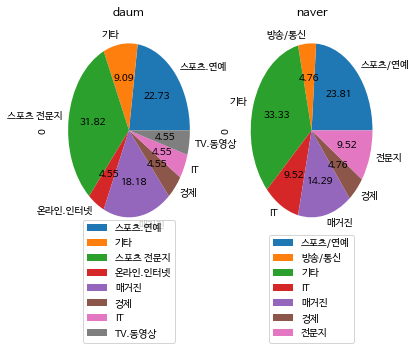

In [261]:
ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(onlyDaum['category']), orient='index')[0].plot(kind = 'pie',autopct='%.2f', fontsize=10)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(onlyNaver['category']), orient='index')[0].plot(kind = 'pie',autopct='%.2f', fontsize=10)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

In [262]:
onlyDaum[['count','prop']].sum()

count    579.00000
prop       0.06178
dtype: float64

In [263]:
onlyNaver[['count','prop']].sum()

count    529.000000
prop       0.034987
dtype: float64